In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
import os

In [2]:
# Between two nlm states
transition_dipole_moment = stark_int(n_1=50, n_2=51, l_1=0, l_2=1, m_1=0, m_2=0)
transition_dipole_moment

491.5268274202669

In [3]:
# In an electric field (with B=0)
# quantum numbers
nmin = 10
nmax = 11
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
# field orientation
field_orientation = 'crossed'
# field-free Hamiltonian
H_0 = np.diag(En)
# find the off-diagonal terms of the Stark interaction matrix
mat_S = stark_matrix(neff, L_vals, m_vals, field_orientation)

calculate Stark terms: 100%|█████████████████| 221/221 [00:02<00:00, 94.48it/s]


In [44]:
# specify the electric field
field = np.linspace(0.00, 18000.0, 201) # V /cm
field_au = field * 100 * e * a_0 / En_h
# specify the magnetic field (in Telsa)
#B_z = 1.5776E-3
# (in atomic units)
#B_z_au = B_z / (2.35*10**5)
# Zeeman interaction Hamiltonian
#H_Z = np.diag(E_zeeman(m_vals, B_z_au))
# diagonalise for each field
eig_vals, eig_vecs = stark_map_vec(H_0, mat_S, field_au)

diagonalise Hamiltonian: 100%|██████████████| 201/201 [00:01<00:00, 186.07it/s]


In [45]:
np.shape(eig_vals[10])

(221,)

State: 		 n= 11 , l= 0 , m= 0
Character: 	 n= 10 , l= 9 , m= 9


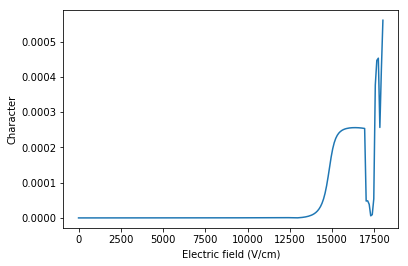

In [101]:
state = 100
character = 99
print('State: \t\t n=', n_vals[state], ', l=', L_vals[state], ', m=', m_vals[state])
print('Character: \t n=', n_vals[character], ', l=', L_vals[character], ', m=', m_vals[character])

plt.plot(field, np.abs(eig_vecs[:,character,state]))
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')

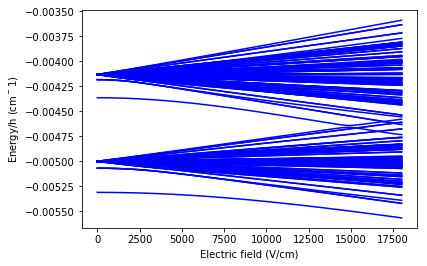

In [102]:
for i in np.arange(0, len(eig_vals[0]), 1): 
    plt.plot(field, eig_vals[:,i], '-b')
    
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/h (cm$^-1$)')

State: 		 n= 11 , l= 1 , m= 0
Character: 		 l= 1


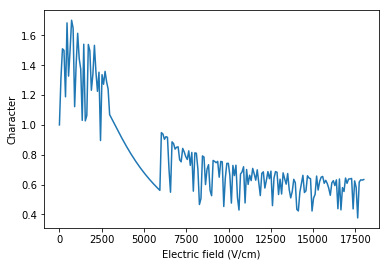

In [124]:
state = 102
L_char = 1
print('State: \t\t n=', n_vals[state], ', l=', L_vals[state], ', m=', m_vals[state])
print('Character: \t\t l=', L_char )

plt.plot(field, np.sum( np.abs( (eig_vecs[:,np.where(L_vals==L_char), L_vals[state]])[:,0,:] ), axis=1 ) )
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Character')